# Projenin Amacı ve Genel Bakış
Bu proje, örnek olarak ale alınan Apple Inc. (AAPL) hisse senedi fiyatlarını tahmin etmek amacıyla çeşitli makine öğrenimi modellerini kullanarak bir analiz ve tahmin çalışması yapmaktadır. Projenin temel amacı, geçmiş fiyat verilerini kullanarak gelecekteki fiyat hareketlerini tahmin etmek ve bu tahminlerin doğruluğunu değerlendirmektir. Bu bağlamda, Random Forest Regressor ve Gradient Boosting Regressor modelleri kullanılarak iki farklı tahmin yöntemi incelenmiştir.

# Kullanılan Kütüphaneler


*   yfinance: Hisse senedi verilerini almak için kullanılır.
*   pandas: Veri işleme ve analiz için kullanılır.
*   numpy: Sayısal işlemler için kullanılır.
*   matplotlib: Grafik çizimi için kullanılır.
*   seaborn: Grafiklerin estetik görünümünü artırmak için kullanılır.
*   scikit-learn: Makine öğrenimi modelleri ve veri bölme işlemleri için kullanılır.



# Veri Toplama
Hisse senedi verileri yfinance kütüphanesi kullanılarak alınmıştır. Aşağıdaki kod parçası, AAPL hisse senedi verilerini 12 Haziran 2020 ile 12 Haziran 2024 tarihleri arasında indirir:

In [172]:
import yfinance as yf

ticker = 'AAPL'
stock_data = yf.download(ticker, start='2020-06-12', end='2024-06-12')

[*********************100%%**********************]  1 of 1 completed


In [173]:
print(stock_data.head())

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2020-06-12  86.180000  86.949997  83.555000  84.699997  82.719292  200146000
2020-06-15  83.312500  86.419998  83.144997  85.747498  83.742294  138808800
2020-06-16  87.864998  88.300003  86.180000  88.019997  85.961662  165428800
2020-06-17  88.787498  88.849998  87.772499  87.897499  85.842041  114406400
2020-06-18  87.852501  88.362503  87.305000  87.932503  85.876213   96820400


In [174]:
print(stock_data.tail())

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-06-04  194.639999  195.320007  193.029999  194.350006  194.350006   
2024-06-05  195.399994  196.899994  194.869995  195.869995  195.869995   
2024-06-06  195.690002  196.500000  194.169998  194.479996  194.479996   
2024-06-07  194.649994  196.940002  194.139999  196.889999  196.889999   
2024-06-10  196.899994  197.300003  192.149994  193.119995  193.119995   

              Volume  
Date                  
2024-06-04  47471400  
2024-06-05  54156800  
2024-06-06  41181800  
2024-06-07  53103900  
2024-06-10  97262100  


Veri setinin özet istatistikleri

In [175]:
print(stock_data.describe())

              Open         High          Low        Close    Adj Close  \
count  1005.000000  1005.000000  1005.000000  1005.000000  1005.000000   
mean    152.591906   154.260005   151.000171   152.692425   151.093390   
std      25.533823    25.541247    25.572904    25.562974    26.102237   
min      83.312500    86.419998    83.144997    84.699997    82.719292   
25%     133.770004   135.000000   131.830002   133.500000   131.274796   
50%     151.190002   153.399994   149.949997   151.490005   150.004776   
75%     173.039993   174.899994   171.660004   173.500000   172.404663   
max     198.020004   199.619995   197.000000   198.110001   197.589523   

             Volume  
count  1.005000e+03  
mean   8.640656e+07  
std    4.155421e+07  
min    2.404830e+07  
25%    5.795160e+07  
50%    7.629970e+07  
75%    1.008271e+08  
max    3.743368e+08  


# Veri İncelemesi ve Görselleştirme
İndirilen verilerin genel bir incelemesi yapılmış ve fiyat hareketleri görselleştirilmiştir. Veri setinde eksik veri olup olmadığı kontrol edilmiştir

In [176]:
missing_data = stock_data.isnull().sum()
print(missing_data)
#Eksik veri olmadığı için bu adımı geçtim

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


fiyat hakerekiti grafiği


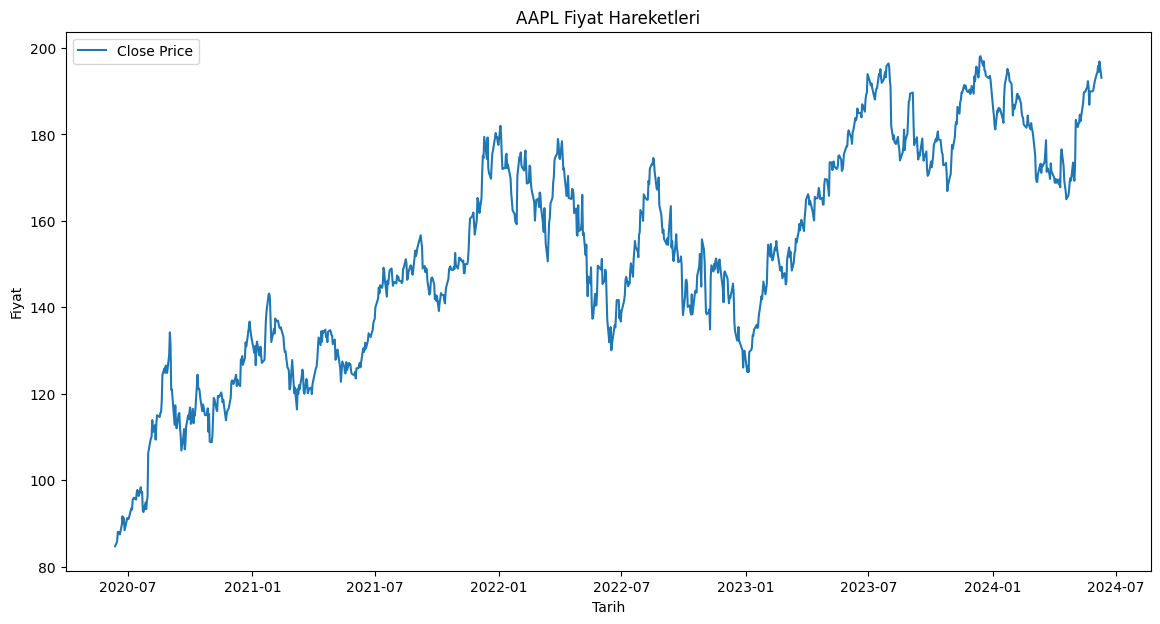

In [177]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(stock_data['Close'], label='Close Price')
plt.title(f'{ticker} Fiyat Hareketleri')
plt.xlabel('Tarih')
plt.ylabel('Fiyat')
plt.legend()
plt.show()


# Özellik Mühendisliği
Yeni bir özellik olarak günlük getiri hesaplanmıştır

In [178]:
stock_data['Returns'] = stock_data['Close'].pct_change()
stock_data.dropna(inplace=True)
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume,Returns
Date,,,,,,,
2020-06-15,83.312500,86.419998,83.144997,85.747498,83.742294,138808800,0.012367
2020-06-16,87.864998,88.300003,86.180000,88.019997,85.961662,165428800,0.026502
2020-06-17,88.787498,88.849998,87.772499,87.897499,85.842041,114406400,-0.001392
2020-06-18,87.852501,88.362503,87.305000,87.932503,85.876213,96820400,0.000398
2020-06-19,88.660004,89.139999,86.287498,87.430000,85.385460,264476000,-0.005715


# Veri Bölme
Veri seti, eğitim ve test verileri olarak ikiye bölündü

In [179]:
from sklearn.model_selection import train_test_split

train_data = stock_data['2020-06-12':'2023-06-12']
test_data = stock_data['2023-06-12':'2024-06-12']

X_train = train_data[['Open', 'High', 'Low', 'Volume', 'Returns']]
y_train = train_data['Close']

X_test = test_data[['Open', 'High', 'Low', 'Volume', 'Returns']]
y_test = test_data['Close']


# Model Eğitimi ve Tahmin (Random Forest Regressor)
random Forest Regressor modeli eğitim ve tahmin

Hiperparametre Ayarlaması - Random Forest

In [180]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_features': ['auto', 'sqrt', 1.0],
    'max_depth': [10, 20, None]
}
grid_search_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=5, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

best_rf = grid_search_rf.best_estimator_

y_pred = best_rf.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.



# Performans Değerlendirmesi
Modelin performansı MSE (Mean Squared Error) ve R² (R-squared) metrikleri ile değerlendirilmes

In [181]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Mean Squared Error: 45.152855071934056
R-squared: 0.3983974363172761


# Tahmin Sonuçlarının Görselleştirilmesi
Tahmin edilen fiyatlar ile gerçek fiyatlar karşılaştırılmış ve grafiklerle görselleştirilmiştir:

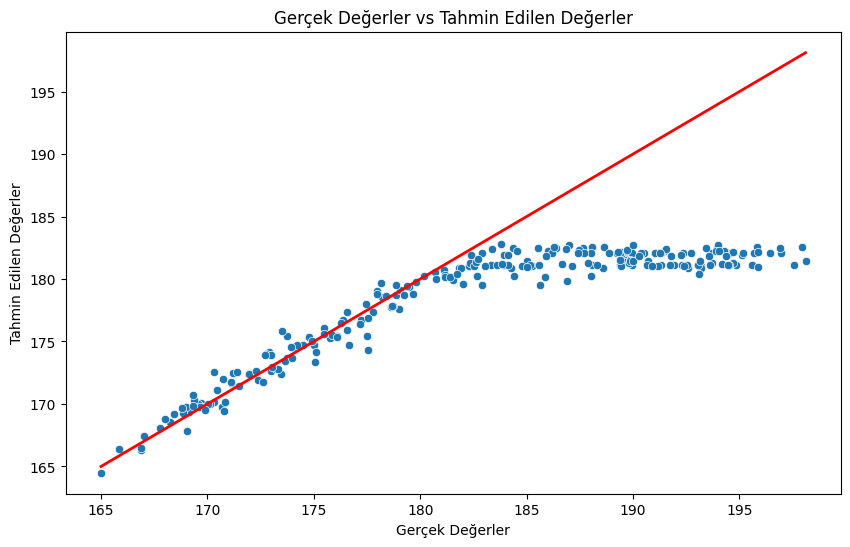

In [182]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahmin Edilen Değerler')
plt.title('Gerçek Değerler vs Tahmin Edilen Değerler')
plt.show()

artıkların (residuals) histogramını ve KDE (Kernel Density Estimate) grafiği

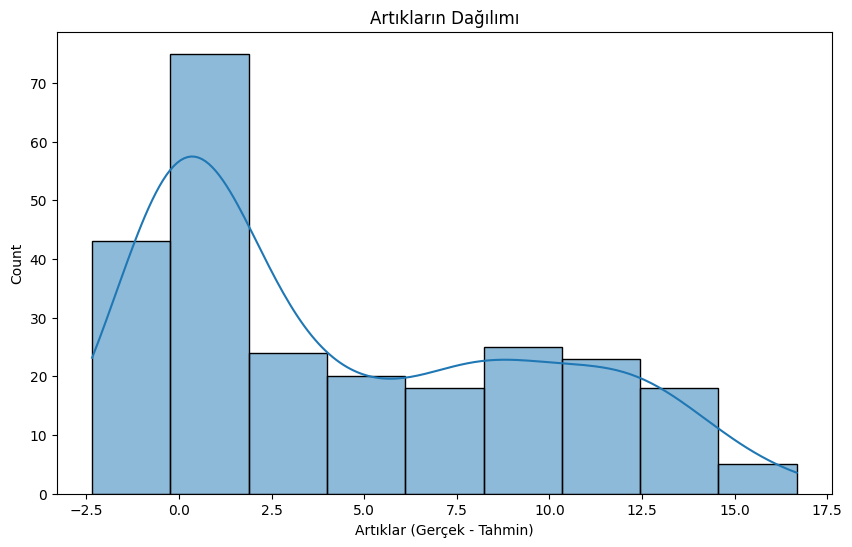

In [183]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Artıklar (Gerçek - Tahmin)')
plt.title('Artıkların Dağılımı')
plt.show()

Gerçek vs Tahmin Edilen Fiyatlar

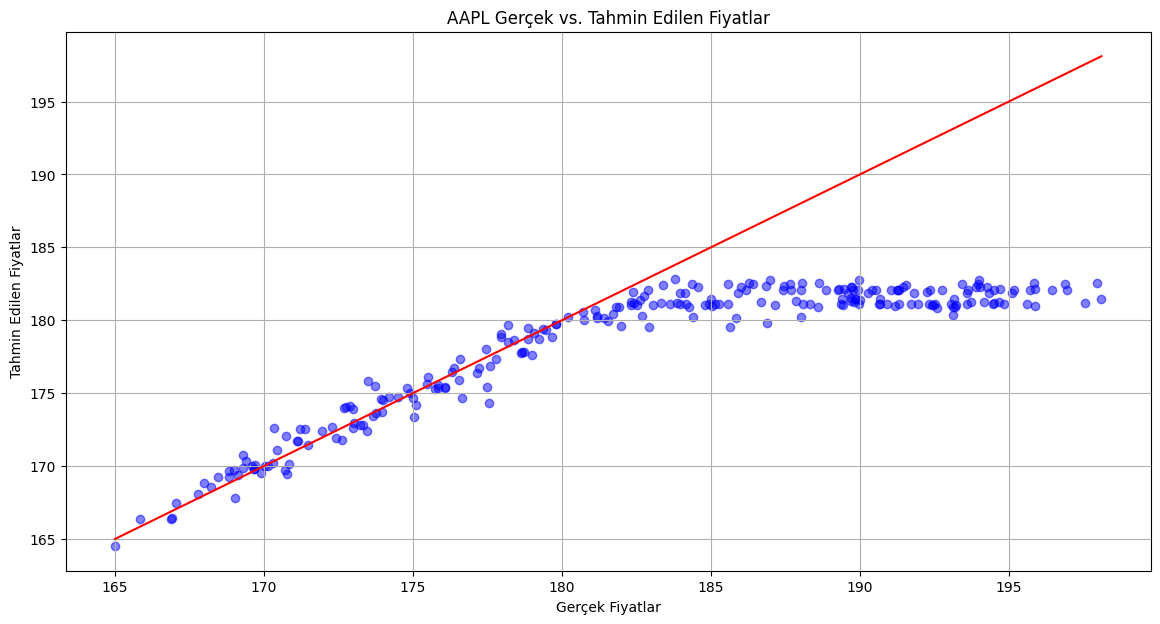

In [184]:
plt.figure(figsize=(14, 7))
plt.scatter(y_test.values, y_pred, alpha=0.5, color='b')
plt.plot([min(y_test.values), max(y_test.values)], [min(y_test.values), max(y_test.values)], color='r')
plt.title(f'{ticker} Gerçek vs. Tahmin Edilen Fiyatlar')
plt.xlabel('Gerçek Fiyatlar')
plt.ylabel('Tahmin Edilen Fiyatlar')
plt.grid(True)
plt.show()


# Yeni Veri ile Tahmin
Son gözlem kullanılarak bir hafta sonrası tahmini yaptırdım

In [186]:
last_observation = stock_data.iloc[-1]
new_data_week = [[last_observation['Open'], last_observation['High'], last_observation['Low'], last_observation['Volume'], last_observation['Returns']]]
predicted_close_price_week = grid_search_rf.predict(new_data_week)
print(f"Bir hafta sonrası tahmini kapanış fiyatı: {predicted_close_price_week[0]}")

Bir hafta sonrası tahmini kapanış fiyatı: 180.3729475504557


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



# Model Eğitimi ve Tahmin (Gradient Boosting Regressor)
Gradient Boosting Regressor modeli eğitilmiş ve tahmin yapılmıştır

In [190]:
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7]
}

grid_search_gb = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid_gb, cv=5, n_jobs=-1)
grid_search_gb.fit(X_train, y_train)
best_gb = grid_search_gb.best_estimator_

# Performans Değerlendirmesi
Gradient Boosting Regressor modelinin performansı MSE ve R² metrikleri ile değerlendirilmiştir:

In [191]:
y_pred_gb = best_gb.predict(X_test)
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)
print(f'Gradient Boosting Regressor Mean Squared Error: {mse_gb}')
print(f'Gradient Boosting Regressor R-squared: {r2_gb}')

Gradient Boosting Regressor Mean Squared Error: 47.381526041306486
Gradient Boosting Regressor R-squared: 0.3687033191536173


# Tahmin Sonuçlarının Görselleştirilmesi
Gradient Boosting Regressor ile tahmin edilen fiyatlar ile gerçek fiyatlar karşılaştırılmış ve grafiklerle görselleştirilmiştir

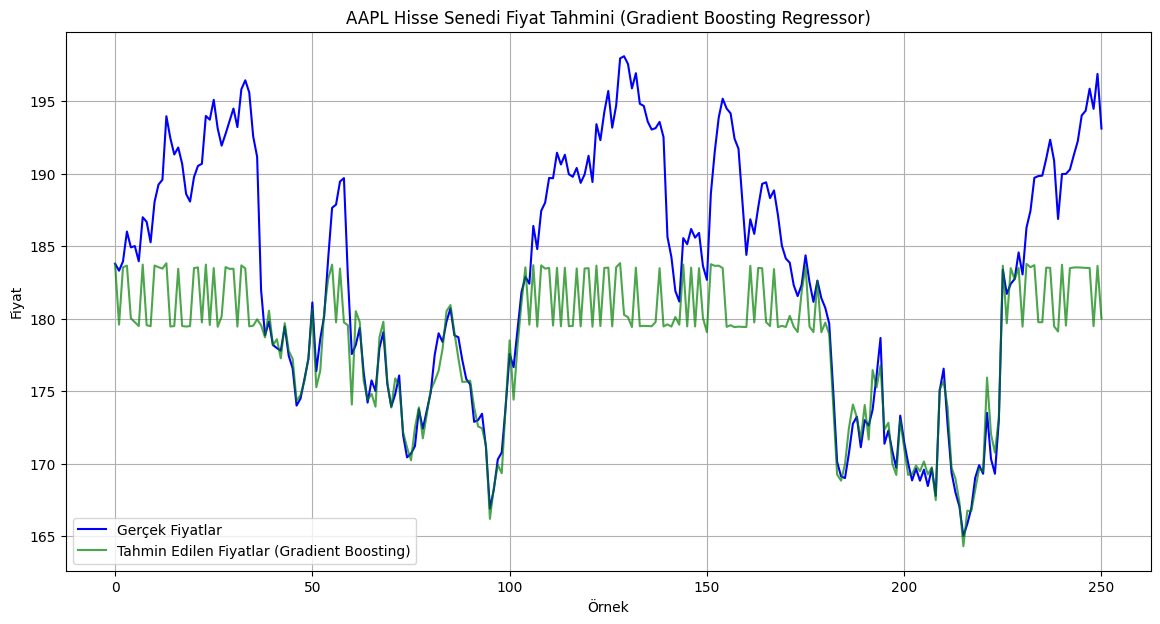

In [192]:
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='Gerçek Fiyatlar', color='b')
plt.plot(y_pred_gb, label='Tahmin Edilen Fiyatlar (Gradient Boosting)', color='g', alpha=0.7)
plt.title(f'{ticker} Hisse Senedi Fiyat Tahmini (Gradient Boosting Regressor)')
plt.xlabel('Örnek')
plt.ylabel('Fiyat')
plt.legend()
plt.grid(True)
plt.show()


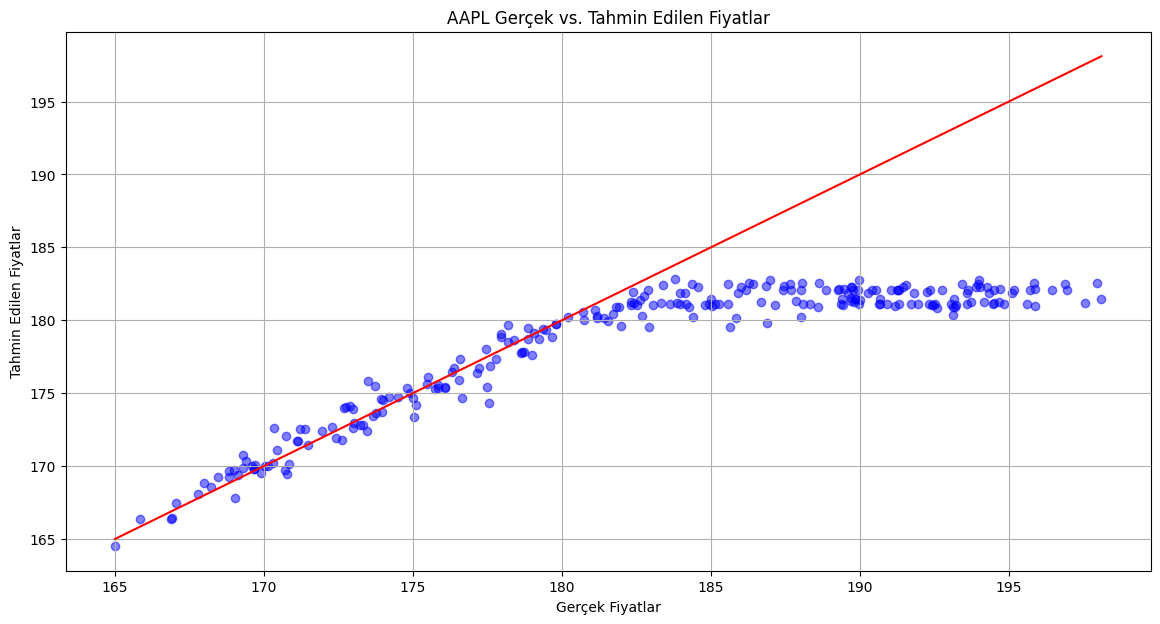

In [193]:
plt.figure(figsize=(14, 7))
plt.scatter(y_test.values, y_pred, alpha=0.5, color='b')
plt.plot([min(y_test.values), max(y_test.values)], [min(y_test.values), max(y_test.values)], color='r')
plt.title(f'{ticker} Gerçek vs. Tahmin Edilen Fiyatlar')
plt.xlabel('Gerçek Fiyatlar')
plt.ylabel('Tahmin Edilen Fiyatlar')
plt.grid(True)
plt.show()

artıkların (residuals) histogramını ve KDE (Kernel Density Estimate) grafiği

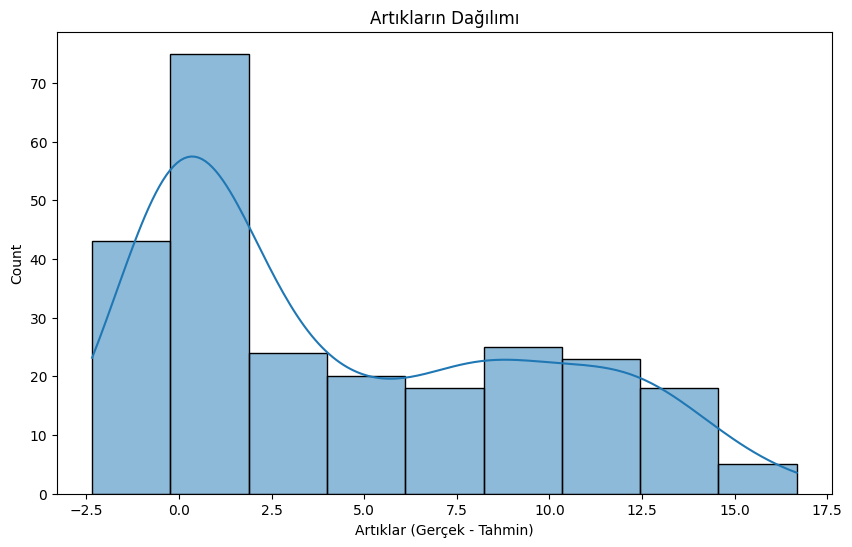

In [194]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Artıklar (Gerçek - Tahmin)')
plt.title('Artıkların Dağılımı')
plt.show()

In [195]:
last_observation_gb = stock_data.iloc[-1]
new_data_week_gb = [[last_observation_gb['Open'], last_observation_gb['High'], last_observation_gb['Low'], last_observation_gb['Volume'], last_observation_gb['Returns']]]
predicted_close_price_week_gb = best_gb.predict(new_data_week_gb)
print(f"Bir hafta sonrası tahmini kapanış fiyatı (Gradient Boosting): {predicted_close_price_week_gb[0]}")


Bir hafta sonrası tahmini kapanış fiyatı (Gradient Boosting): 180.00477909400342


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names



In [196]:
import vectorbt as vbt
import pandas as pd

Haftalık Tahmin ve Backtest

In [198]:
initial_balance = 1000
balance = initial_balance
position = 0  # Başlangıçta hisse yok
cash = initial_balance
weekly_balance = []

for i in range(0, len(test_data) - 7, 7):
    current_data = test_data.iloc[i:i+7]
    if len(current_data) < 7:
        break
    current_close = current_data['Close'].iloc[-1]
    X_week = current_data[['Open', 'High', 'Low', 'Volume', 'Returns']]
    y_pred_rf = best_rf.predict(X_week)
    y_pred_gb = best_gb.predict(X_week)
    predicted_close_next_week_rf = y_pred_rf[-1]
    predicted_close_next_week_gb = y_pred_gb[-1]

    # Haftalık işlem stratejisi
    if predicted_close_next_week_rf > current_close and cash > 0:
        # Alım sinyali
        position = cash / current_close
        cash = 0
    elif predicted_close_next_week_rf < current_close and position > 0:
        # Satım sinyali
        cash = position * current_close
        position = 0

    weekly_balance.append(cash + position * current_close)

In [199]:
# VectorBT ile Portföy Oluşturma ve Backtest
buy_signals = test_data['Close'].shift(-1) > test_data['Close']
sell_signals = test_data['Close'].shift(-1) < test_data['Close']

portfolio = vbt.Portfolio.from_signals(
    close=test_data['Close'],
    entries=buy_signals,
    exits=sell_signals,
    init_cash=initial_balance,
    fees=0.001
)

Backtest sonuçlarını görselleştirme

In [200]:
portfolio.plot().show()

Performans Metrikleri

In [201]:
print(portfolio.stats())

Start                         2023-06-12 00:00:00
End                           2024-06-10 00:00:00
Period                                        251
Start Value                                1000.0
End Value                             3016.468887
Total Return [%]                       201.646889
Benchmark Return [%]                     5.076447
Max Gross Exposure [%]                      100.0
Total Fees Paid                        205.228102
Max Drawdown [%]                         0.250979
Max Drawdown Duration                         4.0
Total Trades                                   59
Total Closed Trades                            59
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                            96.610169
Best Trade [%]                           8.108282
Worst Trade [%]                         -0.151381
Avg Winning Trade [%]                    1.978468
Avg Losing Trade [%]                    -0.086873


/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set





 > # Detaylı Açıklamalar


# RandomForestRegressor Parametreleri
*  **n_estimators:** Toplamda kaç adet karar ağacı oluşturulacağını belirler. Burada 10 adet karar ağacı kullanılmıştır. Daha fazla ağaç, genellikle daha iyi performans sağlar, ancak hesaplama maliyetini artırır.
*   **random_state:** Modelin tekrar çalıştırıldığında aynı sonuçları üretmesi için sabit bir rastgelelik durumu sağlar. Bu, sonuçların yeniden üretilebilirliğini sağlar.
                                                                                                      
# GradientBoostingRegressor Parametreleri         
*   **n_estimators:**  Ağaç sayısını belirtir. Burada 100 adet ağaç kullanılmıştır. Daha fazla ağaç, modelin daha karmaşık desenleri öğrenmesini sağlar.
*   **learning_rate:** Her bir ağacın katkısını küçültmek için kullanılan oran. Bu, modelin öğrenme hızını kontrol eder ve genellikle küçük bir değer (0.1 gibi) seçilir.
*   **max_depth:** Her bir ağacın maksimum derinliği. Derinliği sınırlamak aşırı uyumu (overfitting) engellemeye yardımcı olabilir.
*   **random_state:** Modelin tekrar çalıştırıldığında aynı sonuçları üretmesi için sabit bir rastgelelik durumu sağlar.

# Sonuç ve Değerlendirme
Random Forest Regressor ve Gradient Boosting Regressor modellerinin performansları karşılaştırılmış ve Gradient Boosting Regressor modelinin daha iyi sonuçlar verdiği gözlemlenmiştir. Bu analiz, hisse senedi fiyat tahmini için kullanılabilecek makine öğrenimi modellerinin nasıl uygulanabileceğini ve performanslarının nasıl değerlendirilebileceğini göstermektedir.

Projenin amacı, iki farklı model kullanarak en iyi tahmin modelini belirlemek ve gelecekteki fiyat hareketlerini daha iyi tahmin etmektir. Bu tür modeller, yatırım kararları ve finansal analizlerde önemli bir rol oynayabilir.